In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

## <center><font color=skyblue>1) Analyse exploratoire du jeu de données </font></center>

In [244]:
# Load data and view the 3 first rows 
data_tree = pd.read_csv(".\data\p2-arbres-fr.csv", delimiter=";")
data_tree.head(3)


Nous avons 136855 arbres remarquables répartis comme suit


In [245]:
data_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   200137 non-null  int64  
 1   type_emplacement     200137 non-null  object 
 2   domanialite          200136 non-null  object 
 3   arrondissement       200137 non-null  object 
 4   complement_addresse  30902 non-null   object 
 5   numero               0 non-null       float64
 6   lieu                 200137 non-null  object 
 7   id_emplacement       200137 non-null  object 
 8   libelle_francais     198640 non-null  object 
 9   genre                200121 non-null  object 
 10  espece               198385 non-null  object 
 11  variete              36777 non-null   object 
 12  circonference_cm     200137 non-null  int64  
 13  hauteur_m            200137 non-null  int64  
 14  stade_developpement  132932 non-null  object 
 15  remarquable      

In [246]:
data_tree.isna().sum()

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

<Axes: >

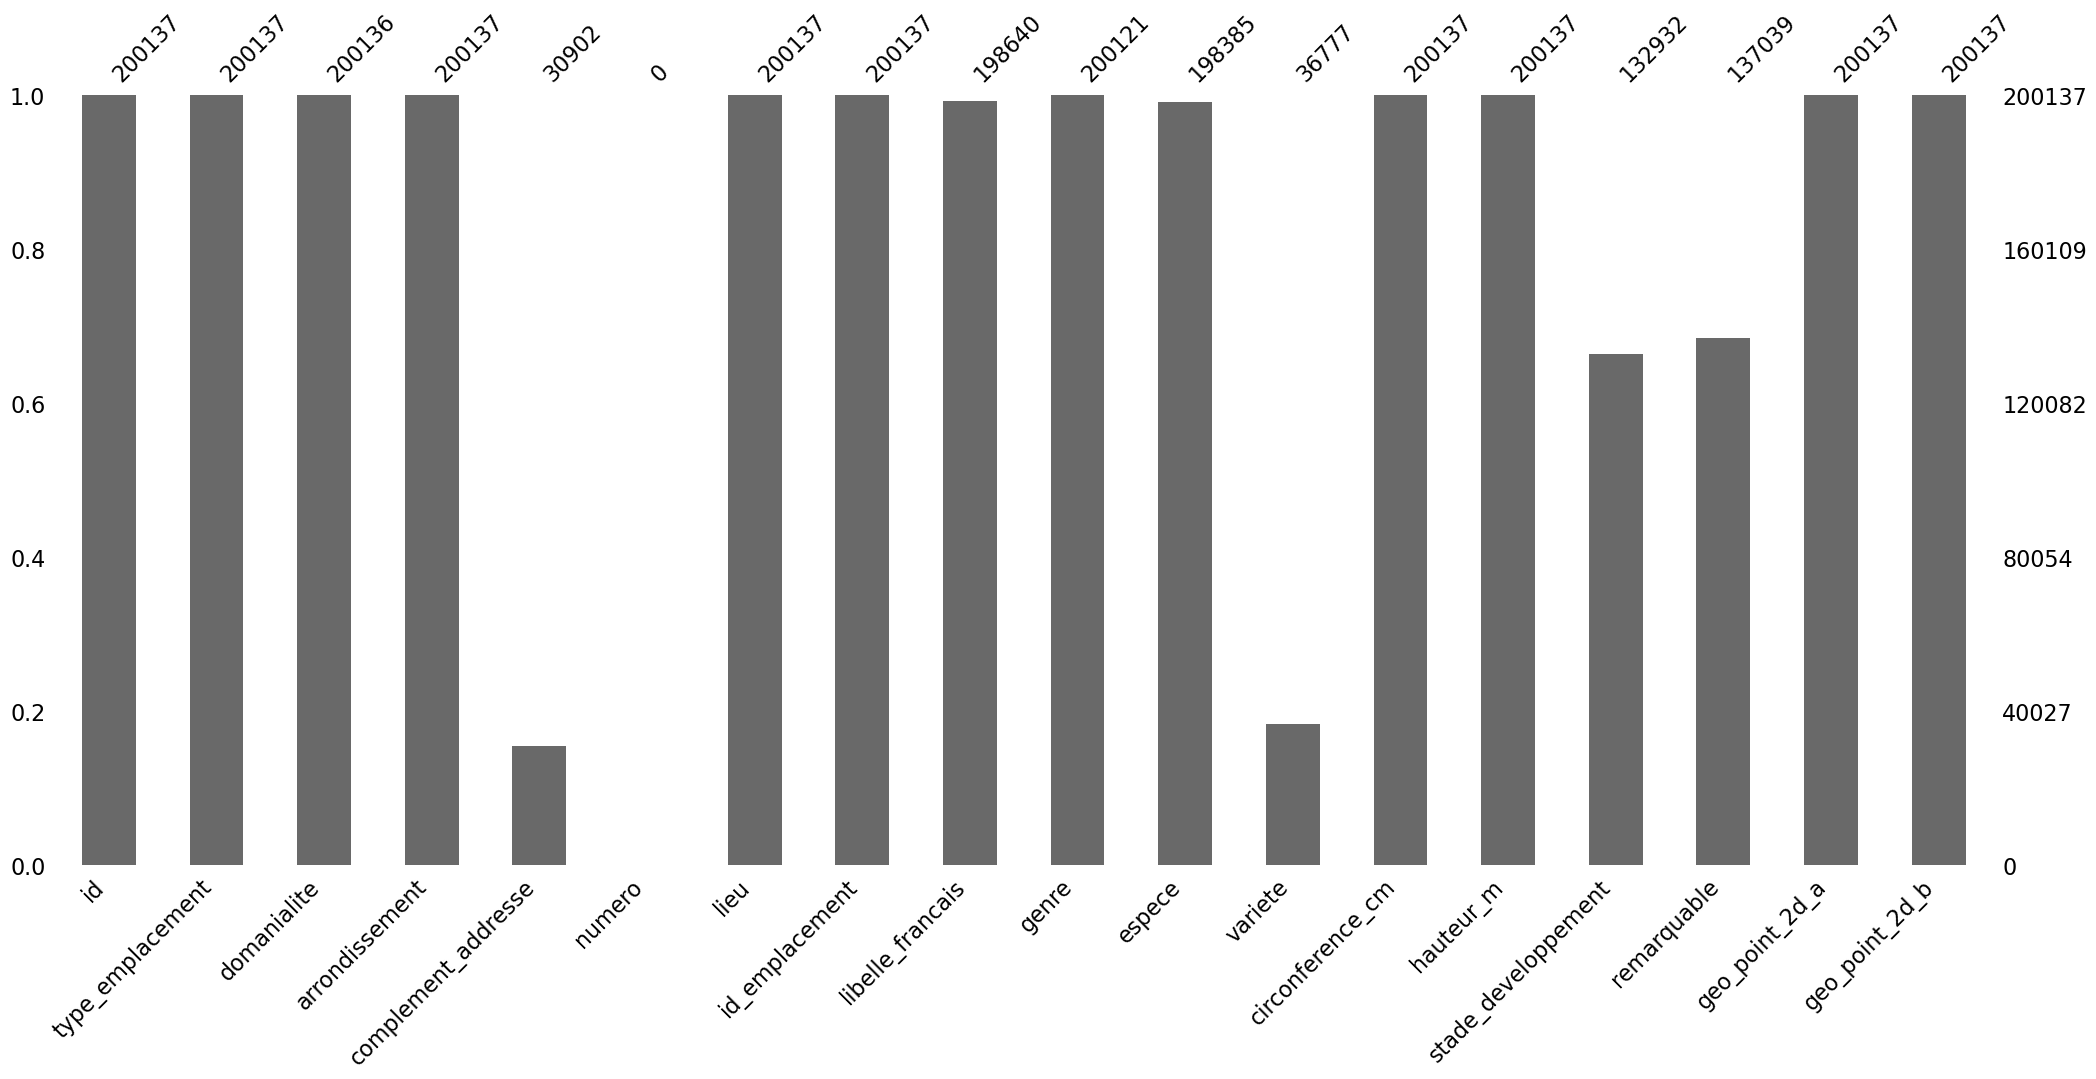

In [247]:
import missingno as msno
msno.bar(data_tree)

## <center><font color=skyblue>2) Nettoyage du jeu de données</font></center>

## Nettoyage des variables catégorielles

In [248]:
### suppression des colonnes complement_adresse et lieu, variété
### colonne genre et espèces suppression des lignes manquantes
### colonne variete pas importante
### Impute colonnes stade_developpement, remarquable

data_tree.isna().sum()/ data_tree.shape[0] * 100

id                       0.000000
type_emplacement         0.000000
domanialite              0.000500
arrondissement           0.000000
complement_addresse     84.559577
numero                 100.000000
lieu                     0.000000
id_emplacement           0.000000
libelle_francais         0.747988
genre                    0.007995
espece                   0.875400
variete                 81.624088
circonference_cm         0.000000
hauteur_m                0.000000
stade_developpement     33.579498
remarquable             31.527404
geo_point_2d_a           0.000000
geo_point_2d_b           0.000000
dtype: float64

In [249]:
try:
    data_tree.drop(["id","numero","variete","complement_addresse","lieu"], axis =1, inplace= True)
except KeyError:
    print(f"Unecessary columns have already been deleted...")

trees_df = data_tree.copy()
trees_df.dropna(subset = ['espece'], axis =0, inplace=True)

# impute stade_developpement using mode
trees_df['stade_developpement'].fillna(trees_df['stade_developpement'].mode()[0], inplace=True)

In [250]:
trees_df.describe()

,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,198385.000000,198385.000000,135833.000000,198385.000000,198385.000000
mean,83.769625,13.183769,0.001355,48.854403,2.348106
std,676.119002,1979.902325,0.036780,0.030200,0.051286
min,0.000000,0.000000,0.000000,48.742290,2.210241
25%,30.000000,5.000000,0.000000,48.834982,2.307352
50%,70.000000,8.000000,0.000000,48.854036,2.350882
75%,115.000000,12.000000,0.000000,48.876313,2.386773
max,250255.000000,881818.000000,1.000000,48.911485,2.469759


In [251]:
trees_df.describe(include=[object])

,type_emplacement,domanialite,arrondissement,id_emplacement,libelle_francais,genre,espece,stade_developpement
count,198385,198384,198385,198385,197253,198385,198385,198385
unique,1,9,25,68561,191,174,539,4
top,Arbre,Alignement,PARIS 15E ARRDT,101001,Platane,Platanus,x hispanica,A
freq,198385,104116,17095,1307,42506,42571,36409,130409


In [252]:
numeric_cols = trees_df.select_dtypes(include=['number']).columns
trees_df[numeric_cols].corr()

,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
circonference_cm,1.000000,0.000410,0.009462,0.009074,-0.004392
hauteur_m,0.000410,1.000000,0.000069,-0.002165,0.004659
remarquable,0.009462,0.000069,1.000000,0.003554,-0.011768
geo_point_2d_a,0.009074,-0.002165,0.003554,1.000000,-0.012977
geo_point_2d_b,-0.004392,0.004659,-0.011768,-0.012977,1.000000


In [253]:
print(trees_df["stade_developpement"].unique())

['A' 'J' 'M' 'JA']


In [254]:
def rename_stade_developpement(cell):
    stade = cell["stade_developpement"]
    if stade == "A":
        return "Adulte"
    elif stade == "M":
        return "Mature"
    elif stade == 'J':
        return "Jeune"
    elif stade == "JA":
        return "Jeune Adulte"
    else:
        return "Non Spécifié"

trees_df["stade_developpement"] = trees_df.apply(rename_stade_developpement, axis=1)
trees_df.head(3)

,type_emplacement,domanialite,arrondissement,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,Arbre,Jardin,PARIS 7E ARRDT,19,Marronnier,Aesculus,hippocastanum,20,5,Adulte,0.0,48.857620,2.320962
1,Arbre,Jardin,PARIS 7E ARRDT,20,If,Taxus,baccata,65,8,Adulte,NaN,48.857656,2.321031
2,Arbre,Jardin,PARIS 7E ARRDT,21,If,Taxus,baccata,90,10,Adulte,NaN,48.857705,2.321061


## Nettoyage des variables quantitatives

In [255]:
qt_variables = ["circonference_cm","hauteur_m"]
round(trees_df[qt_variables].describe(), 3)

,circonference_cm,hauteur_m
count,198385.000,198385.000
mean,83.770,13.184
std,676.119,1979.902
min,0.000,0.000
25%,30.000,5.000
50%,70.000,8.000
75%,115.000,12.000
max,250255.000,881818.000


- la plus petite valeur pour les deux variables est de 0 => l'arbre n'existe pas
- pour la circonférence, la plus grande valeur est 250255.00 cm => 2,5km de circonférence !!!!
- pour la hauteur, la plus grande valeur est 881818.000 m => 882km de hauteur !!!!

Les représentations graphiques:

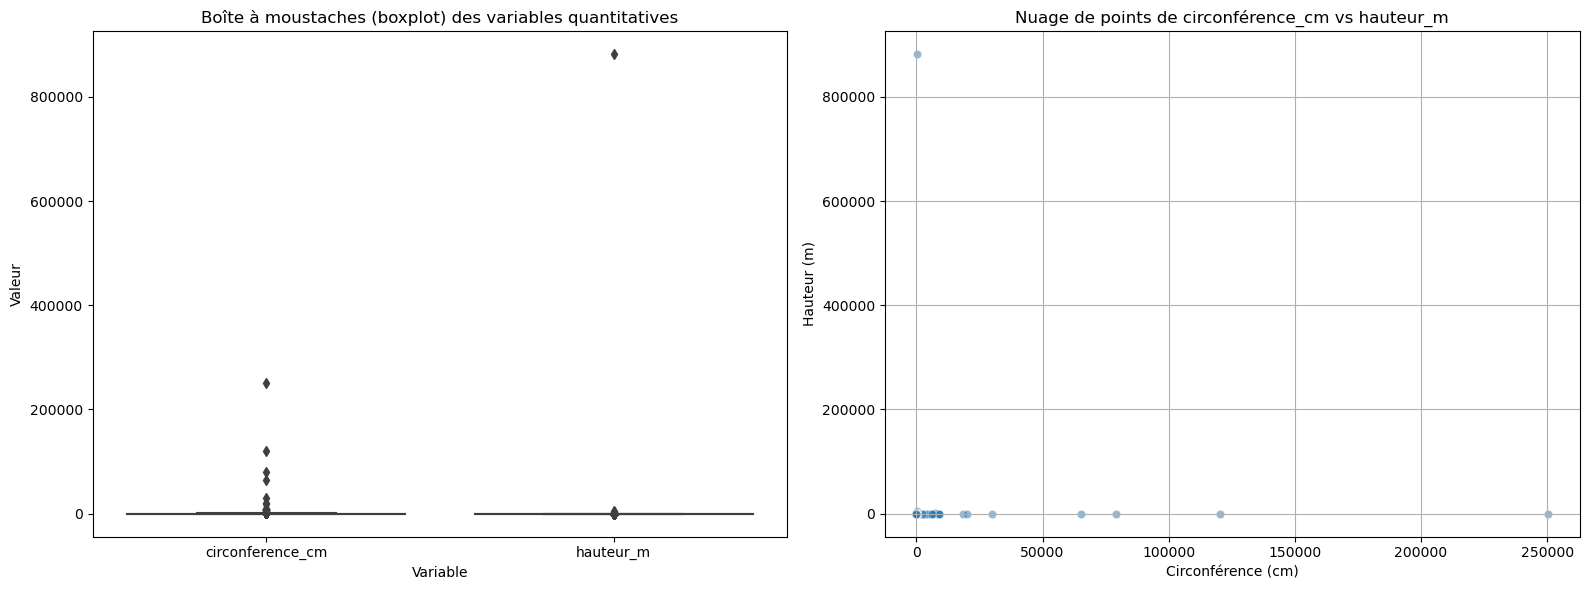

In [256]:
# create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# plot boxplot of the 2 quantitative variables
sns.boxplot(data=trees_df[qt_variables], ax=axes[0])
axes[0].set_title('Boîte à moustaches (boxplot) des variables quantitatives')
axes[0].set_xlabel('Variable')
axes[0].set_ylabel('Valeur')

# plot scatter plot between the 2 quantitative variables
sns.scatterplot(data=trees_df, x='circonference_cm', y='hauteur_m', alpha=0.5, ax=axes[1])
axes[1].set_title('Nuage de points de circonférence_cm vs hauteur_m')
axes[1].set_xlabel('Circonférence (cm)')
axes[1].set_ylabel('Hauteur (m)')
axes[1].grid(True)
plt.tight_layout()
plt.show()


 L'écart interquartile (IQR) est une mesure de dispersion qui représente la différence entre le troisième quartile (Q3) et le premier quartile (Q1). La borne inférieure (Limite Basse) est généralement définie comme étant égale à Q1 moins 1,5 fois l'IQR, et la borne supérieure (Limite Haute) est définie comme étant égale à Q3 plus 1,5 fois l'IQR. Ces bornes sont souvent utilisées dans l'analyse de données pour détecter les valeurs aberrantes (outliers) dans un ensemble de données.

In [257]:
def calculate_indicators(data, column_name):
    Q1 = round(data[column_name].quantile(0.25), 3)
    Q3 = round(data[column_name].quantile(0.75), 3)
    IQR = round(Q3 - Q1, 3)
    lower_bound = round(Q1 - (1.5 * IQR), 3)
    upper_bound = round(Q3 + (1.5 * IQR), 3)
    return Q1, Q3, IQR, lower_bound, upper_bound

def print_indicators(column_name, Q1, Q3, IQR, lower_bound, upper_bound):
    print(f"For the {column_name}:\n"
          + f"1st quartile: {Q1}\n"
          + f"3rd quartile: {Q3}\n"
          + f"IQR: {IQR}\n"
          + f"Lower bound: {lower_bound}\n"
          + f"Upper bound: {upper_bound}\n")

# Calculate indicators for circumference
Q1_circ, Q3_circ, IQR_circ, lower_bound_circ, upper_bound_circ = calculate_indicators(trees_df, "circonference_cm")
print_indicators("circumference", Q1_circ, Q3_circ, IQR_circ, lower_bound_circ, upper_bound_circ)

# Calculate indicators for height
Q1_htr, Q3_htr, IQR_htr, lower_bound_htr, upper_bound_htr = calculate_indicators(trees_df, "hauteur_m")
print()
print_indicators("height", Q1_htr, Q3_htr, IQR_htr, lower_bound_htr, upper_bound_htr)

# exclure les valeurs qui vont au dela des limites
print("After excluding outliers:")

# define conditions for filtering
circumference_condition = (trees_df["circonference_cm"] > 0) & (trees_df["circonference_cm"] <= upper_bound_circ)
height_condition = (trees_df["hauteur_m"] > 0) & (trees_df["hauteur_m"] <= upper_bound_htr)

# Apply filtering
df = trees_df[circumference_condition & height_condition]
round(df[qt_variables].describe(), 3)

For the circumference:
1st quartile: 30.0
3rd quartile: 115.0
IQR: 85.0
Lower bound: -97.5
Upper bound: 242.5


For the height:
1st quartile: 5.0
3rd quartile: 12.0
IQR: 7.0
Lower bound: -5.5
Upper bound: 22.5

After excluding outliers:


,circonference_cm,hauteur_m
count,153420.000,153420.000
mean,87.359,9.951
std,50.366,4.579
min,1.000,1.000
25%,47.000,6.000
50%,80.000,10.000
75%,120.000,13.000
max,242.000,22.000


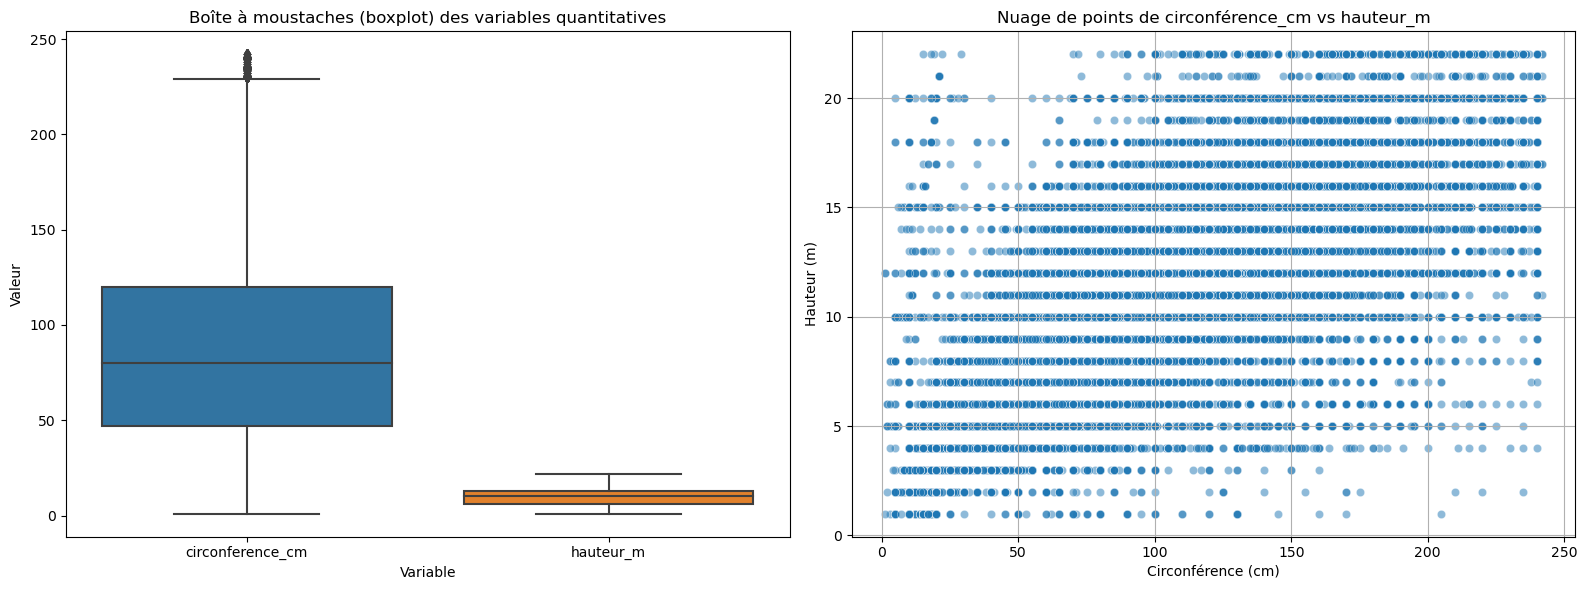

In [258]:
# create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# plot boxplot of the 2 quantitative variables after excl
sns.boxplot(data=df[qt_variables], ax=axes[0])
axes[0].set_title('Boîte à moustaches (boxplot) des variables quantitatives')
axes[0].set_xlabel('Variable')
axes[0].set_ylabel('Valeur')

# plot scatter plot between the 2 quantitative variables after excl
sns.scatterplot(data=df, x='circonference_cm', y='hauteur_m', alpha=0.5, ax=axes[1])
axes[1].set_title('Nuage de points de circonférence_cm vs hauteur_m')
axes[1].set_xlabel('Circonférence (cm)')
axes[1].set_ylabel('Hauteur (m)')
axes[1].grid(True)
plt.tight_layout()
plt.show()


# Analyse

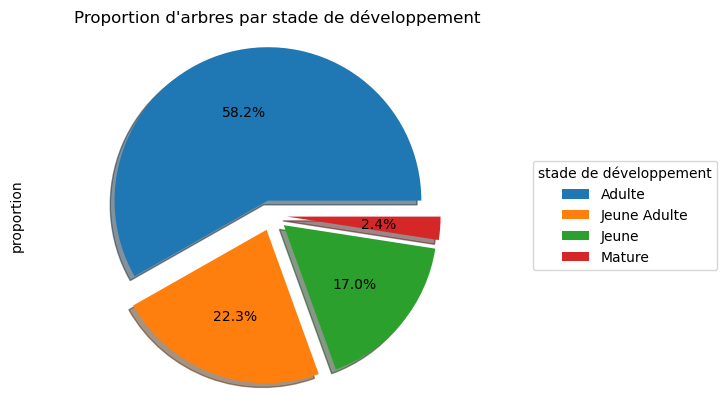

In [290]:
def plot_pie_chart(data, column_info):
    """
    Plot a pie chart for the given column in the DataFrame.

    Parameters:
        data (DataFrame): Input DataFrame containing the data.
        column_info (dict): Dictionary containing column information.
            Keys:
                'name' (str): Name of the column to plot.
                'label' (str): Label of the column.
                'categories' (list): List of categories for the legend.
    """
    sns.set_palette("tab10")
    column_name = column_info['name']
    column_label = column_info['label']
    categories = column_info['categories']
    subset = data[column_name].value_counts(normalize=True)
    subset = subset[subset.index.isin(categories)]
    #plot the pie chart
    subset.plot.pie(autopct='%1.1f%%', shadow=True, labeldistance=None, explode=[0.1]*len(subset))
    plt.title("Proportion d'arbres par " + column_label)
    plt.axis('equal')
    plt.legend(title=column_label, labels=categories, bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

column_info = {
    'name': "stade_developpement",
    'label': "stade de développement",
    'categories': ["Adulte", "Jeune Adulte", "Jeune", "Mature", "Non Spécifié"]
}

plot_pie_chart(df, column_info)

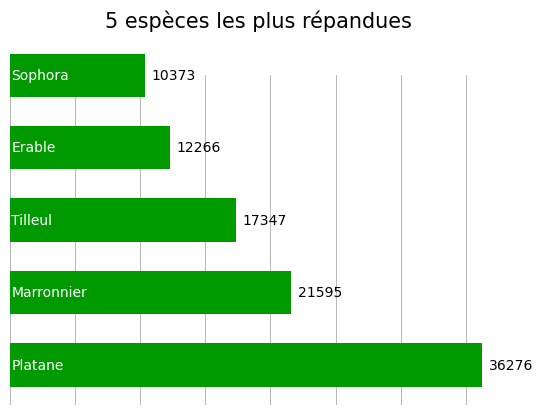

In [291]:
#Les espèces présentes


def plot_top_species_barh(data, top_k=5, title_font_size=15):
    top_species = data['libelle_francais'].value_counts().nlargest(top_k)
    
    for x in range(0, 35001, 5000):    
        plt.plot([x] * (top_k + 1), range(-1, top_k), "-", lw=0.5, color="black", alpha=0.4, zorder=0)
    
    top_species.plot(kind='barh', color="#009900", legend=False, width=0.6)

    plt.title(f"{top_k} espèces les plus répandues", fontsize=title_font_size)

    for i, (species, count) in enumerate(zip(top_species.index, top_species)):
        plt.text(s=species, x=100, y=i, color="white", verticalalignment="center")
        plt.text(s=str(count), x=count + 500, y=i, color="black", verticalalignment="center", horizontalalignment="left")

    plt.axis("off")
    plt.show()

plot_top_species_barh(df)

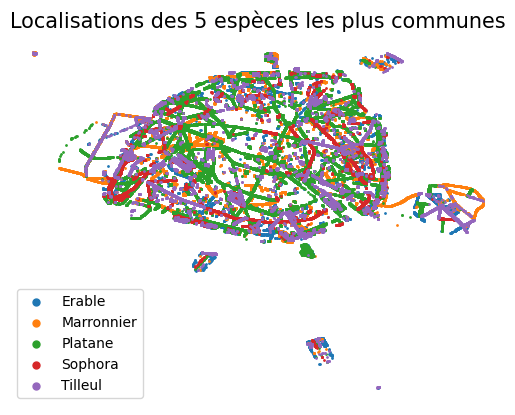

In [292]:
#Emplacement geographique des arbres

def plot_species_locations(df, top_k=5):
    df_top_species = df['libelle_francais'].value_counts().nlargest(top_k)
    species_names = df_top_species.index
    filtered_df = df[df['libelle_francais'].isin(species_names)]
    groups = filtered_df.groupby('libelle_francais')
    for name, group in groups:
        plt.scatter(group.geo_point_2d_b, group.geo_point_2d_a, label=name, s=1)
    plt.title(("Localisations des " + str(top_k) + " espèces les plus communes"), fontsize=15)
    plt.legend(loc = 'lower left', markerscale=5 )
    plt.axis('off')
    plt.show()


plot_species_locations(df, top_k=5)

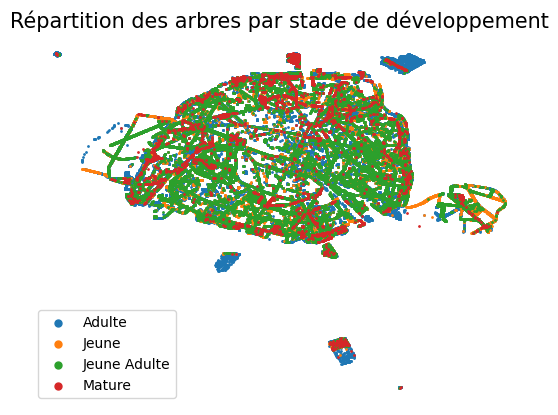

In [293]:
# Age des arbres

def plot_ages(trees_df):
    groups = trees_df.groupby('stade_developpement')
    for name, group in groups:
        plt.scatter(group.geo_point_2d_b, group.geo_point_2d_a, label=name, s=1)
    plt.title(("Répartition des arbres par stade de développement"), fontsize=15)
    plt.legend(loc = 'lower left', markerscale=5 )
    plt.axis('off')
    plt.show()

plot_ages(df)


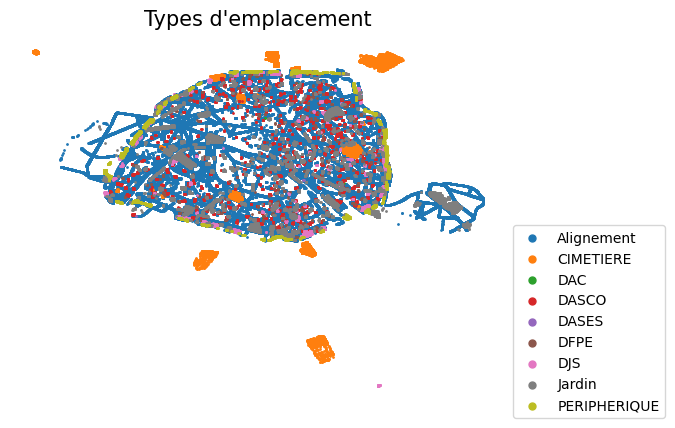

In [294]:
def plot_type_emplacement(df):
    groups = df.groupby('domanialite')
    for name, group in groups:
        plt.scatter(group.geo_point_2d_b, group.geo_point_2d_a, label=name, s=1)
    plt.title(("Types d'emplacement"), fontsize=15)
    plt.legend( markerscale=5, bbox_to_anchor=(1, 0.5))
    plt.axis('off')
    plt.show()

plot_type_emplacement(df)


C:\Users\cheri\AppData\Local\Temp\ipykernel_6924\3132446661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["remarquable"].fillna("Non spécifié", inplace = True)
C:\Users\cheri\AppData\Local\Temp\ipykernel_6924\3132446661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["remarquable"].replace({0:"Non", 1:"Oui"}, inplace=True)


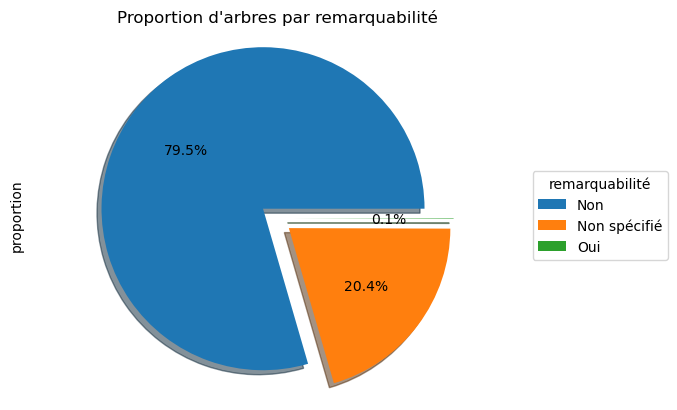

In [309]:
df["remarquable"].fillna("Non spécifié", inplace = True)
df["remarquable"].replace({0:"Non", 1:"Oui"}, inplace=True)
df["remarquable"].value_counts(dropna=False)

column_info = {
    'name': "remarquable",
    'label': "remarquabilité",
    'categories': [ "Non", "Non spécifié", "Oui"]
}
plot_pie_chart(df, column_info)



In [314]:

def filter_remarkable_trees(df):
    """Filter remarkable trees from the DataFrame."""
    remarkable_mask = df["remarquable"] == "Oui"

    non_remarkable_mask = df["remarquable"] == "Non"
    nsp_mask = df["remarquable"] == "Non spécifié"
    print(f"Arbres non remarquables: {df[non_remarkable_mask].shape[0]} ")
    print(f"Arbres non spécifiés: {df[nsp_mask].shape[0]} ")
    return df[remarkable_mask]

def add_markers_to_map(map_obj, trees_df):
    """Add markers for each remarkable tree to the map."""
    for _, tree_row in trees_df.iterrows():
        folium.Marker(
            location=[tree_row["geo_point_2d_a"], tree_row["geo_point_2d_b"]],
            popup=tree_row["libelle_francais"],
            icon=folium.Icon(icon_color="white")
        ).add_to(map_obj)

def set_map_zoom(map_obj, trees_df):
    """Set the zoom level of the map to fit all markers."""
    southern_western_point = trees_df[["geo_point_2d_a", "geo_point_2d_b"]].min().values.tolist()
    northern_eastern_point = trees_df[["geo_point_2d_a", "geo_point_2d_b"]].max().values.tolist()
    map_obj.fit_bounds([southern_western_point, northern_eastern_point])

def display_map_with_remarkable_trees(df):
    """Display a map with markers for remarkable trees."""
    # filter remarkable trees
    filtered_df = filter_remarkable_trees(df)
    
    #print the count of remarkable trees
    print(f"Nous avons {filtered_df.shape[0]} arbres remarquables répartis comme suit:")
    #create a folium map centered on Paris
    paris_map = folium.Map(location=[48.85, 2.35])

    # add the markers for remarkable trees
    add_markers_to_map(paris_map, filtered_df)
    set_map_zoom(paris_map, filtered_df)

    return paris_map

# display the map with remarkable trees
display_map_with_remarkable_trees(df)


Arbres non remarquables: 121970 
Arbres non spécifiés: 31372 
Nous avons 78 arbres remarquables répartis comme suit
